---
# Using the Bayesian method to delineate the influence zones of data clusters
---

In this example, we generate a dataset containing 3 data clusters with gaussian probability distribution functions. 
The (X, C) dataset contains the 2-D positions X and the class C of each data point.  

When we train a classifier on a dataset with a <i>one-versus-the-rest</i> decision function, we usually get the 
probability of each observation X given a class: $P(X|C_{i})$. <br>

For example, $P(X|C_{1})$ is the probability of observing X in class 1. When $P(X|C_{1})=0$, the observation X 
should be found in classes 2 or 3.   <br>

Using the <i>a priori</i> class probabilities $P(C_{i})$, we can use Bayes method to obtain the more usefull
<i>a posteriori</i> class probabilities $P(C_{i}|X)$. <br>

Indeed, we are generally more interested in predicting the most probable class associated to a given observation X than
knowing the probability of observing X in a given class.

In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from sklearn import svm
from sklearn.datasets import make_blobs
import seaborn as sns
sns.set(color_codes=True)

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


Parameters for the three gaussian clusters:

In [2]:
# Cluster centroids
mu = [(-5, 0), (-1, 4), (4, 2)]

# Cluster standard deviations
sigma = [0.5, 0.5, 0.5]

# Cluster A-PRIORI class probabilities
prob_C = np.array([0.4, 0.3, 0.3]) 

# Total number of points
npts = 1000

# Number of datapoints in each cluster
n = (npts*prob_C).astype(int)

Generate the 2-D dataset containing the 3 isotropic gaussian clusters 

In [3]:
X, C = make_blobs(n_samples=n, centers=mu, cluster_std = sigma, n_features=2, shuffle=False, random_state=42)

Generate a uniform (x,y) grid enclosing the 2-D datapoints

In [4]:
# Grid spatial domain
x_min, x_max = -7.0, 6.0
y_min, y_max = -1.5, 6.0

# Number of grid spacings
nx, ny = 200, 200

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))   

Train a classifier using the (X, C) dataset. The type of classifier used here is not very important as long as it 
outputs the probability of each observation in each class: $P(X|C_{i})$   <br>

For convenience and visual effect, we use an SVM classifier. Others could also be used.

In [5]:
clf = svm.SVC(kernel='rbf', gamma=0.7, C=1, decision_function_shape='ovr', probability=True);
clf.fit(X, C);

Compute for each point on the grid, the probability of belonging to each class $P(X|C_{i})$

In [6]:
prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Using the last result, compute the <i>a posteriori</i> probabilities $P(C_{i}|X)$ which are 
the probabilities of each class given the observations X <br> 

The <i>a posteriori</i> probabilities are given by: <br>
<blockquote> $P(C_{i}|X) = P(X|C_{i}) P(C_{i}) / P(X)$ </blockquote> <br>

with the normalization factor $P(X)$: <br>
<blockquote> $P(X) = \sum_{i=1}^{3}{P(X|C_{i}) P(C_{i})}$ </blockquote> 

In [7]:
# Compute the a posteriori probability of each cluster
nclusters = prob_C.shape[0]
for i in range(nclusters):
    prob[:,i] = prob[:,i] * prob_C[i]
    
# Normalize the a posteriori probabilities
sum_prob = np.sum(prob, axis=1)
for i in range(nclusters):
    prob[:,i] = prob[:,i]/sum_prob


In [8]:
# Get the maximum a posteriori probability at every grid point
prob = np.max(prob,axis=1)
prob = prob.reshape(xx.shape)


Show the 50% boundaries for the maximum <i>a posteriori</i> probability. Any datapoint within any of them has more than 50% 
chance of belonging to the corresponding class.

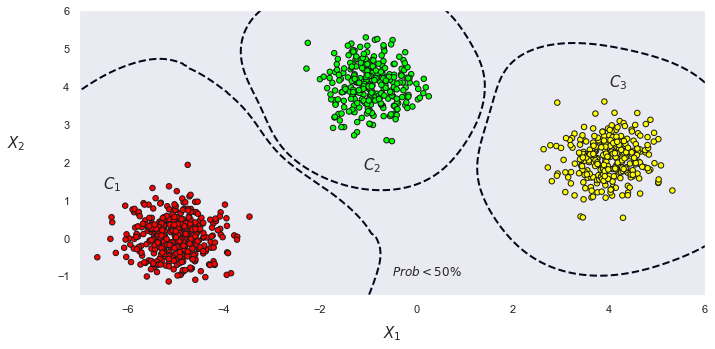

In [11]:
cm_bright = ListedColormap(['#FF0000', '#00FF00', '#FFFF00'])

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X[:, 0], X[:, 1], s=30, c=C, cmap=cm_bright, edgecolors='k')

# Display the 50% boundaries for the maximum a posteriori probability. 
ax.contour(xx, yy, prob, levels=[0.5], linewidths=2,linestyles='dashed')

plt.text(-6.5, 1.3, '$C_{1}$', fontsize=15)
plt.text(-1.1, 1.8, '$C_{2}$', fontsize=15)
plt.text(4., 4, '$C_{3}$', fontsize=15)
plt.text(-0.5, -1, '$Prob<50\%$', fontsize=12)

ax.axis([x_min, x_max, y_min, y_max])
plt.ylabel('$X_{2}$', rotation=0, fontsize=15)
plt.xlabel('$X_{1}$', fontsize=15)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5, -0.1)        
ax.grid(False)
fig.tight_layout()

# Save the figure
plt.savefig('Bayesian classification, 50% contours.png')
plt.savefig('Bayesian classification, 50% contours.pdf')

plt.show()


Show the maximum value of the local <i>a posteriori</i> probabilities $P(C_{i}|X)$. In the blue areas, the probability of belonging to any class is less than 50%; in 
the red areas, it is more than 85%.

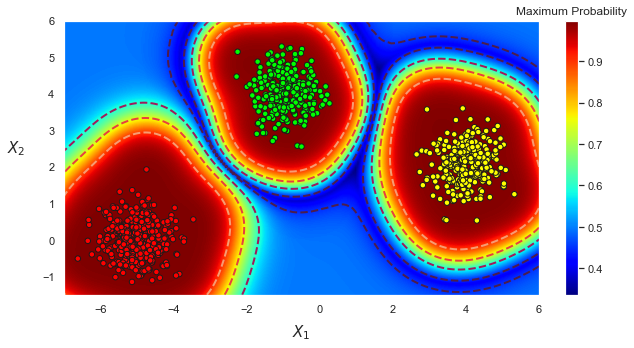

In [12]:

cm_bright = ListedColormap(['#FF0000', '#00FF00', '#FFFF00'])

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X[:, 0], X[:, 1], s=30, c=C, cmap=cm_bright, edgecolors='k')

# Display the maximum a posteriori probabilities  
im = ax.imshow(prob, interpolation='bilinear',
           extent=(x_min, x_max, y_min, y_max), aspect='equal',
           origin='lower', cmap='jet')

ax.contour(xx, yy, prob, levels=5, linewidths=2, linestyles='dashed')
cbar = fig.colorbar(im, ax=ax, fraction=0.028, pad=0.04)
cbar.ax.set_title('Maximum Probability')

ax.axis([x_min, x_max, y_min, y_max])
plt.ylabel('$X_{2}$', rotation=0, fontsize=15)
plt.xlabel('$X_{1}$', fontsize=15)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5, -0.1)        
ax.grid(False)

fig.tight_layout()

# Save the figure
plt.savefig('Bayesian classification, maximum probabilities.png')
plt.savefig('Bayesian classification, maximum probabilities.pdf')

plt.show()
